In [1]:
import numpy as np
import torch as t
from torch.distributions import Normal, Categorical, Bernoulli
from torch.distributions import MultivariateNormal as MvNormal
import matplotlib.pyplot as plt
%matplotlib inline
from ipywidgets import FloatSlider, IntSlider, interact, interact_manual

$$
\newcommand{\bracket}[3]{\left#1 #3 \right#2}
\newcommand{\b}{\bracket{(}{)}}
\newcommand{\Bernoulli}{{\rm Bernoulli}\b}
\newcommand{\Categorical}{{\rm Categorical}\b}
\newcommand{\x}{\mathbf{x}}
\newcommand{\X}{\mathbf{X}}
\newcommand{\m}{\boldsymbol{\mu}}
\newcommand{\P}{{\rm P}\b}
\newcommand{\dd}[2][]{\frac{\partial #1}{\partial #2}}
\newcommand{\S}{\mathbf{\Sigma}}
\newcommand{\Sh}{\mathbf{\hat{\Sigma}}}
\newcommand{\mh}{\boldsymbol{\hat{\mu}}}
\newcommand{\N}{\mathcal{N}\b}
\newcommand{\det}{\bracket{\lvert}{\rvert}}
\newcommand{\sb}{\bracket{[}{]}}
\newcommand{\E}{\mathbb{E}\sb}
\newcommand{\Var}{{\rm Var}\sb}
\newcommand{\Cov}{{\rm Cov}\sb}
\DeclareMathOperator*{\argmax}{arg\,max}
\DeclareMathOperator*{\argmin}{arg\,min}
\newcommand{\ph}{\hat{p}}
\newcommand{\at}{\bracket{.}{\rvert}}
\newcommand{\w}{\mathbf{w}}
\newcommand{\W}{\mathbf{W}}
\newcommand{\W}{\mathbf{W}}
\newcommand{\Wh}{\mathbf{\hat{W}}}
\newcommand{\Y}{\mathbf{Y}}
\newcommand{\L}{\mathcal{L}}
\newcommand{\wh}{\mathbf{\hat{w}}}
\newcommand{\y}{\mathbf{y}}
\newcommand{\0}{\mathbf{0}}
\newcommand{\I}{\mathbf{I}}
\newcommand{\La}{\mathbf{\Lambda}}
\newcommand{\S}{\mathbf{\Sigma}}
\newcommand{\Sprior}{\S_\text{prior}}
\newcommand{\Spost}{\S_\text{post}}
\newcommand{\mprior}{\m_\text{prior}}
\newcommand{\mpost}{\m_\text{post}}
\newcommand{\Xt}{\tilde{\X}}
\newcommand{\yt}{\tilde{\y}}
\newcommand{\p}{\mathbf{p}}
\newcommand{\l}{\boldsymbol{\ell}}
\DeclareMathOperator*{\softmax}{softmax}
\DeclareMathOperator*{\sigmoid}{sigmoid}
$$

<h1> Part 4: Classification </h1>

Classification is almost exactly the same as regression, except that:
<ul>
    <li> The outputs, $y$, are discrete class-labels. </li>
    <li> Almost all interesting/useful algorithms require iterative solutions </li>
</ul>
    
The same considerations are relevant, including,
<ul>
    <li> Overfitting </li>
    <li> Regularisation </li>
    <li> Cross-validation </li>
    <li> Bayes (but this is much harder, as there aren't any exact solutions) </li>
</ul>

<h2> Prerequisites: Bernoulli distribution for two-class classification</h2>
Samples from the Bernoulli distribution are either $0$ or $1$, with probability given by the parameter,

\begin{align}
  \P{y| p} &= \Bernoulli{y; p} = y p + (1-y) (1-p) = \begin{cases}
    p &\text{if } y=1\\
    1-p &\text{if } y=0
  \end{cases}
\end{align}

In [12]:
Py = Bernoulli(probs=0.8)
print(Py.sample((10,)))
print(Py.log_prob(t.tensor([0., 1.])).exp())

tensor([1., 1., 0., 1., 1., 1., 1., 1., 1., 1.])
tensor([0.2000, 0.8000])


<h3> Logit parameterisation of the Bernoulli distribution and the sigmoid </h3>

Working directly with the probabilities turns out to be problematic:
<ul>
    <li> Probabilities live in a strange range, $0 \leq p \leq 1$. </li>
    <li> There is a strong risk of numerical underflow, which breaks algorithms such as (stochastic) gradient descent. </li>
</ul>

Instead, we can also treat the Bernoulli parameter as a logits vector, $\ell$, defined such that,

\begin{align}
  p &= \sigmoid(\ell) = \sigma(\ell)\\
  p &= \frac{1}{1+e^{-\ell}}
\end{align}

Now, no matter what $\l$ is, the probabilities must lie in the right range, and they are much less likely to underflow.

PyTorch allows you to directly use the logit parameterisation,

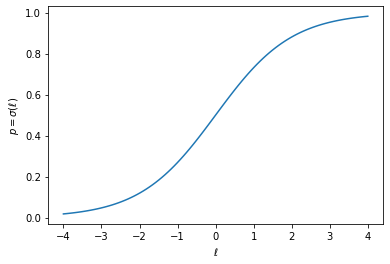

In [13]:
ls = t.linspace(-4, 4, 100)
ps = t.sigmoid(ls)
fig, ax = plt.subplots()
ax.set_xlabel("$\ell$")
ax.set_ylabel("$p = \sigma(\ell)$")
ax.plot(ls, ps);

In [21]:
Py = Bernoulli(logits=0)
print(Py.sample((10,)))
print(Py.log_prob(t.tensor([0., 1.])).exp())

tensor([0., 1., 1., 0., 1., 1., 0., 0., 1., 1.])
tensor([0.5000, 0.5000])


<h2> Prerequisites: Categorical distribution for multi-class classification </h2>

The Bernoulli distribution takes one parameter and gives the probability of two classes.  But what about multiple classes?

Samples from the Categorical distribution are integers $0 \leq y < K$, with probability given explicity by a length $K$ vector of, $\p$,

\begin{align}
  \P{y| \p} &= \Categorical{y; \p} = p_y
\end{align}

In [5]:
#A uniform Categorical distribution,
Py = Categorical(probs=t.ones(10)/10)
print(Py.sample((20,)))

tensor([2, 7, 2, 1, 1, 9, 8, 0, 1, 1, 3, 5, 0, 1, 7, 4, 8, 6, 3, 4])


In [6]:
ys = t.arange(10)
print(ys)
Py.log_prob(ys).exp()

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


tensor([0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
        0.1000])

In [7]:
#A non-uniform Categorical distribution,
p = t.tensor([0.5, 0.1, 0.1, 0.1, 0.1, 0.1])
Py = Categorical(probs=p)
y = Py.sample((20,))
y

tensor([1, 0, 5, 0, 4, 0, 3, 2, 5, 3, 3, 5, 1, 5, 0, 1, 1, 0, 3, 4])

In [8]:
Py.log_prob(t.arange(6)).exp()

tensor([0.5000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000])

<h3> Logit parameterisation of the Categorical distribution and the softmax </h3>

Working directly with the probabilities turns out to be problematic:
<ul>
    <li> Probabilities live in a strange range, $0 \leq p_i \leq 1$. </li>
    <li> Probabilities must sum to $1$. </li>
    <li> There is a strong risk of numerical underflow, which breaks algorithms such as (stochastic) gradient descent. </li>
</ul>

Instead, we can also treat the Categorical parameter as a logits vector, $\l$, defined such that,

\begin{align}
  \p &= \softmax(\l)\\
  p_i &= \frac{e^{\ell_i}}{\sum_{j=0}^{K-1} e^{\ell_j}}
\end{align}

Now, no matter what $\l$ is, the probabilities must lie in the right range, they must normalize, and they are much less likely to underflow.

PyTorch allows you to directly use the logit parameterisation,

In [9]:
# Uniform Categorical
Py = Categorical(logits = -10*t.ones(10))
print(Py.sample((20,)))
print(Py.log_prob(t.arange(10)).exp())

tensor([0, 6, 1, 2, 9, 6, 3, 8, 9, 9, 1, 1, 6, 3, 9, 9, 9, 4, 1, 5])
tensor([0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
        0.1000])


In [10]:
# Non-uniform Categorical
l = t.tensor([1., 0., -1., -2., -10.])
Py = Categorical(logits = l)
print(Py.sample((20,)))
print(Py.log_prob(t.arange(5)).exp())

tensor([0, 0, 2, 0, 1, 1, 0, 2, 0, 2, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0])
tensor([6.4391e-01, 2.3688e-01, 8.7143e-02, 3.2058e-02, 1.0754e-05])


<h2> Formalising maximum-likelihood supervised learning </h2>

For linear regression, the goal was to predict the distribution over a floating-point $y_\lambda$ based on a given value for $\x_\lambda$,

\begin{align}
  \P{y_\lambda| \x_\lambda} &= \N{y_\lambda; \x_\lambda \cdot \w, \sigma^2}
\end{align}

In classification, the goal is similar: we again want to predict a distribution over $y_\lambda$, based on an input, $\x_\lambda$.  The only difference is that here, $y_\lambda$ is an integer from $0$ to $K-1$.  Thus, when we predict a probability over $y_\lambda$ it either needs to be Bernoulli (for two classes), or categorical (if there can be more classes,

\begin{align}
  \P{y_\lambda| \x_\lambda} &= \Bernoulli{y_\lambda; \sigma\b{\x_\lambda \cdot \w}}\\
  \P{y_\lambda| \x_\lambda} &= \Categorical{y_\lambda; \softmax\b{\x_\lambda \cdot \w}}
\end{align}

or

\begin{align}
  \P{\y| \X} &= \prod_\lambda \P{y_\lambda| \x_\lambda} = \Bernoulli{\y; \sigma\b{\X \w}}\\
  \P{\y| \X} &= \prod_\lambda \P{y_\lambda| \x_\lambda} = \Categorical{\y; \softmax\b{\X \w}}
\end{align}

As an example, consider the "Iris" dataset, which is about classifying flowers based on features such as Petal length.

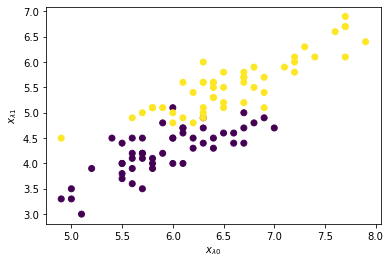

In [24]:
from sklearn import datasets
iris = datasets.load_iris()
_X = t.tensor(iris['data'][50:, [0, 2]]).float()
_Y = (t.tensor(iris['target'][50:])-1).float()

fig, ax = plt.subplots()
ax.set_xlabel("$x_{\lambda 0}$")
ax.set_ylabel("$x_{\lambda 1}$")
ax.scatter(_X[:, 0], _X[:, 1], c=_Y);

Split the data into train and test (we shuffle the data first, because the classes are ordered)

In [36]:
t.manual_seed(0)
perm = t.randperm(_X.shape[0])
X = _X[perm, :]
X = t.cat([X, t.ones(X.shape[0], 1)], -1)
Y = _Y[perm][:, None]

X_train = X[:70, :]
Y_train = Y[:70, :]
X_test  = X[70:, :]
Y_test  = Y[70:, :]

There are some more quicker iterative algorithms.  But they don't add much understanding.  So instead, we use PyTorch-magic to do gradient-descent.

In [28]:
W = t.randn((3,1), requires_grad=True)/100

for i in range(50000):
    L = Bernoulli(logits=X_train@W).log_prob(Y_train).sum()
    
    dW = t.autograd.grad(outputs=L, inputs=(W,))[0]
    if 0==i % 1000:
        print(L.item())
    W.data += 0.001*dW

-48.97450637817383
-20.44990348815918
-17.061649322509766
-15.644775390625
-14.787422180175781
-14.168647766113281
-13.676431655883789
-13.261651039123535
-12.899397850036621
-12.57563304901123
-12.281757354736328
-12.01214599609375
-11.762897491455078
-11.53117561340332
-11.314810752868652
-11.112079620361328
-10.921627044677734
-10.742270469665527
-10.57301139831543
-10.413019180297852
-10.26151180267334
-10.117837905883789
-9.981404304504395
-9.851656913757324
-9.728117942810059
-9.610359191894531
-9.49797534942627
-9.39061450958252
-9.287946701049805
-9.189658164978027
-9.095460891723633
-9.005101203918457
-8.918354988098145
-8.835001945495605
-8.754850387573242
-8.677701950073242
-8.603403091430664
-8.53178882598877
-8.46267032623291
-8.395984649658203
-8.331560134887695
-8.269282341003418
-8.20904541015625
-8.150765419006348
-8.094314575195312
-8.039603233337402
-7.986579895019531
-7.935169219970703
-7.885283470153809
-7.836832046508789


Now, we can plot the classification boundary,

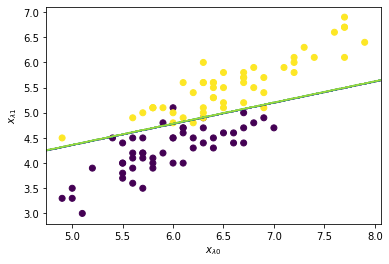

In [14]:
fig, ax = plt.subplots()
ax.set_xlabel("$x_{\lambda 0}$")
ax.set_ylabel("$x_{\lambda 1}$")
ax.scatter(_X[:, 0], _X[:, 1], c=_Y);

x0range = t.linspace(*ax.get_xlim(), 500)
x1range = t.linspace(*ax.get_ylim(), 500)

x0s, x1s = t.meshgrid(x0range, x1range)
xs = t.stack([x0s, x1s, t.ones(500, 500)], -1)

ps = Bernoulli(logits=xs@W.detach()).probs[:, :, 0]
ax.contour(x0s, x1s, 0.5<ps);

Now, we can compute the classification-error,

In [15]:
def class_error(X, Y):
    Py = Bernoulli(logits=X@W)
    pred = 0.5 < Py.probs
    N_correct = (pred == Y).sum()
    print(f"{N_correct}/{X.shape[0]} = {100.*N_correct/X.shape[0]}%")
    
print("Training correct")
class_error(X_train, Y_train)

print("Test correct")
class_error(X_test, Y_test)

Training correct
67/70 = 95.71428680419922%
Test correct
28/30 = 93.33333587646484%


Note that the classifier performs really well on training data, but less well on test data.

This should almost always be true to some extent, and the small difference here shouldn't worry us.

<h2> Overfitting in classification</h2>

In [34]:
def cheb(xs, c):
    # c is int
    coefs = c*[0] + [1]
    return np.polynomial.chebyshev.chebval(xs, coefs)
def chebX(X, order):
    assert (-1 <= X).all() and (X <= 1).all()
    
    xs = []
    for c in range(order):
        xs.append(cheb(X, c))
    return t.cat(xs, 1)
t.manual_seed(0)
N = 100
X = 2*t.rand(N, 1)-1
W_true = t.tensor([[4.]])
Y = Bernoulli(logits=X@W_true).sample()

def plot(order):
    Xe= chebX(X, order)
    W = t.zeros((order, 1), requires_grad=True)

    for i in range(15000):
        L = Bernoulli(logits=Xe@W).log_prob(Y).sum()
        if 0==i % 2000:
            print(L.item())
        dW = t.autograd.grad(outputs=L, inputs=(W,))[0]
        W.data += 0.001*dW
    
    fig, ax = plt.subplots()
    ax.set_xlabel("$x$")
    ax.set_ylabel("probability / $y$")
    ax.scatter(X, Y)
    xs = t.linspace(-1, 1, 100)[:, None]
    ps_fitted = Bernoulli(logits=chebX(xs, order)@W).probs.detach()
    ps_true = Bernoulli(logits=xs@W_true).probs.detach()
    ax.plot(xs, ps_fitted, label="fitted probability")
    ax.plot(xs, ps_true, label="true probability")
    ax.legend()
    
interact_manual(plot, order=IntSlider(min=2, max=30));

interactive(children=(IntSlider(value=2, description='order', max=30, min=2), Button(description='Run Interact…

You can use the same techniques to control overfitting:
<ul>
    <li> Regularisation </li>
    <li> Cross-validation (either on the number of classification errors for test points, or on the test-log-likelihood </li>
    <li> Bayesian inference (though its much harder here because the posterior over the weights doesn't have an analytic form)
<ul>

<h2> Simpler, heuristic methods for classification </h2>

We've seen a bunch of complex methods, and implementing them is often quite involved.  Is there anything simpler?

The answer is yes!

<h3> K-nearest neighbour </h3>

One approach is to look at the nearby datapoints.  If the nearby points come from one class, then the chances are that our datapoint come from the same class.

In [37]:
from sklearn import datasets
iris = datasets.load_iris()
X = t.tensor(iris['data'][50:, [0, 2]]).float()
Y = (t.tensor(iris['target'][50:])-1)[:, None]

def plot(K):
    fig, ax = plt.subplots()
    ax.set_xlabel("$x_{\lambda 0}$")
    ax.set_ylabel("$x_{\lambda 1}$")
    ax.scatter(X[:, 0], X[:, 1], c=Y[:, 0]);

    x0range = t.linspace(*ax.get_xlim(), 500)
    x1range = t.linspace(*ax.get_ylim(), 500)

    x0s, x1s = t.meshgrid(x0range, x1range)
    xs = t.stack([x0s, x1s], -1)

    X_exp = X[:, None, None, :]
    
    dist2 = ((X_exp - xs)**2).sum(-1)
    elems = (-dist2).topk(K, dim=0).indices
    pred = (0.5<Y[elems, 0].float().mean(0)).float()
    ax.contour(x0s, x1s, pred)
    
interact_manual(plot, K=IntSlider(min=1, max=11, step=2));

interactive(children=(IntSlider(value=1, description='K', max=11, min=1, step=2), Button(description='Run Inte…

<h3> Cross-validation </h3>

Choose $K$ using cross-validation.  Note that leave-one-out cross validation is very suitable here, as we make a prediction for each point, based on its neighbours, in parallel.

<h3> Weighted-nearest neighbour </h3>

This approach is to take a weighted average of nearby datapoints,

\begin{align}
  p_y(\x) &= \frac{\sum_{\lambda}k(\x, \x_{\lambda}) \delta_{y, y_{\lambda}}}{\sum_{\lambda} k(\x, \x_{\lambda})}
\end{align}

where we might use a squared-exponential kernel/weights (but many other choices are available),

\begin{align}
  k(\x_\lambda, \x_{\lambda'}) = e^{-(\x_\lambda - \x_{\lambda'})^2/(2 b)}
\end{align}

where $b$ is a bandwidth/lengthscale parameter.

In [30]:
def plot(bandwidth):
    fig, ax = plt.subplots()
    ax.set_xlabel("$x_{\lambda 0}$")
    ax.set_ylabel("$x_{\lambda 1}$")
    ax.scatter(X[:, 0], X[:, 1], c=Y[:, 0]);

    x0range = t.linspace(*ax.get_xlim(), 500)
    x1range = t.linspace(*ax.get_ylim(), 500)

    x0s, x1s = t.meshgrid(x0range, x1range)
    xs = t.stack([x0s, x1s], -1)

    X_exp = X[:, None, None, :]

    dist2 = ((X_exp - xs)**2).sum(-1)
    ws = t.exp(-dist2/(2*bandwidth**2))
    print(ws.shape)
    pred = (ws*Y[:, :, None]).sum(0) / ws.sum(0)
    ax.contour(x0s, x1s, 0.5<pred);
    
interact_manual(plot, bandwidth=FloatSlider(min=0.15, max=1., step=0.01));

interactive(children=(FloatSlider(value=0.15, description='bandwidth', max=1.0, min=0.15, step=0.01), Button(d…

<h3> Cross-validation </h3>

Choose bandwidth using cross-validation.  Note that leave-one-out cross validation is very suitable here, as we make a prediction for each point, based on its neighbours, in parallel.

<h2> Nearest centroids </h2>

Saw this in the lab.  Here we compute the center of the inputs for each class, and to classify a new input point, we ask which cluster-center it is closest to.

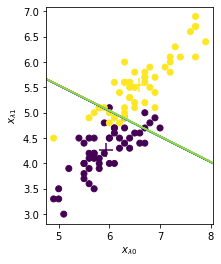

In [33]:
fig, ax = plt.subplots()
ax.set_xlabel("$x_{\lambda 0}$")
ax.set_ylabel("$x_{\lambda 1}$")
ax.scatter(X[:, 0], X[:, 1], c=Y[:, 0]);

mu0 = (X*(1-Y)).sum(0) / (1-Y).sum()
mu1 = (X*Y).sum(0) / Y.sum()

ax.scatter(t.tensor([mu0[0], mu1[0]]), t.tensor([mu0[1], mu1[1]]), c=t.tensor([0., 1.]), s=200, marker="+")
ax.set_aspect('equal', 'box')

x0range = t.linspace(*ax.get_xlim(), 500)
x1range = t.linspace(*ax.get_ylim(), 500)

x0s, x1s = t.meshgrid(x0range, x1range)
xs = t.stack([x0s, x1s], -1)

d0 = ((xs - mu0)**2).sum(-1)
d1 = ((xs - mu1)**2).sum(-1)
pred = d1 < d0 

ax.contour(x0s, x1s, pred);

<h2> Using Bayes theorem to do classification </h2>

Nearest centroid works quite poorly, because it only takes into account the mean of the classes, not their shape.

To take into account the shape of these distributions, it turns out that we can use Bayes theorem to compute a probability distribution over the class-label (in contrast to previously, where we used Bayes theorem to compute a distribution over the parameters for linear regression).

In particular, above we directly learned weights that map directly from the data point to a distribution over class labels.  Here, we separately learn a distribution over data-points for a single class, $\P{\x| y}$.  And we could in principle use this distribution to generate $\x$ that look like the input points from that class.

We can also use Bayes theorem to give us the probability of a class, conditioned on a data-point,

\begin{align}
  \P{y| \x} &= \frac{\P{y} \P{\x| y}}{\P{\x}} \propto \P{y} \P{\x| y}.
\end{align}

The simplest example is to take,

\begin{align}
  \P{\x| y} &= \N{\x; \m_{y}, \sigma^2 \I}.
\end{align}

This ends up being equivalent to nearest-centroid!

In particular, consider a uniform prior,

\begin{align}
  \P{y} = 1/K
\end{align}

so the posterior becomes proportional to the likelihood,

\begin{align}
  \P{y| \x} &\propto \P{\x| y} = \N{\x; \m_y, \sigma^2 \I}.
\end{align}

And the prediction is the class with the highest probability density.

Converting to the log-domain (remembering that the log-transform is monotonically increasing, so it doesn't change the ordering),

\begin{align}
  \log \P{y| \x} &= \log \N{\x; \m_y, \sigma^2 \I} + \text{const}\\
  &= -\tfrac{1}{2\sigma^2} \b{\x - \m_y}^2 + \text{const}\\
\end{align}

So the highest-probability class is the one with the smallest distance between the input, $\x_\lambda$, and the mean for that class, $\m_y$.

Critically, once we have this probabilistic representation, we get a recipe for doing a better job, by taking into account the shape of the input distributions.  In particular, we can fit multivariate normals to the input points,

\begin{align}
  \P{\x| y} = \N{\x; \m_y, \S_y}.
\end{align}

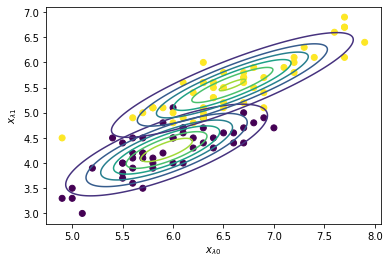

In [20]:
fig, ax = plt.subplots()
ax.set_xlabel("$x_{\lambda 0}$")
ax.set_ylabel("$x_{\lambda 1}$")
ax.scatter(X[:, 0], X[:, 1], c=Y[:, 0]);

X0 = X[Y[:, 0]==0, :]
X1 = X[Y[:, 0]==1, :]

mu0 = X0.mean(0)
mu1 = X1.mean(0)

C0 = (X0-mu0).t() @ (X0-mu0) / X0.shape[0]
C1 = (X1-mu1).t() @ (X1-mu1) / X1.shape[0]

N0 = MvNormal(mu0, C0)
N1 = MvNormal(mu1, C1)


x0range = t.linspace(*ax.get_xlim(), 500)
x1range = t.linspace(*ax.get_ylim(), 500)
x0s, x1s = t.meshgrid(x0range, x1range)
xs = t.stack([x0s, x1s], -1)

ax.contour(x0s, x1s, N0.log_prob(xs).exp())
ax.contour(x0s, x1s, N1.log_prob(xs).exp());

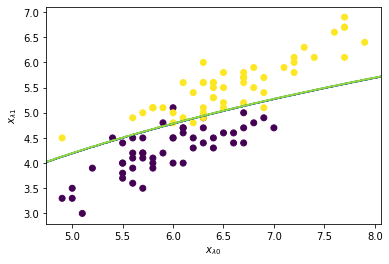

In [21]:
fig, ax = plt.subplots()
ax.set_xlabel("$x_{\lambda 0}$")
ax.set_ylabel("$x_{\lambda 1}$")
ax.scatter(X[:, 0], X[:, 1], c=Y[:, 0]);

x0range = t.linspace(*ax.get_xlim(), 500)
x1range = t.linspace(*ax.get_ylim(), 500)
x0s, x1s = t.meshgrid(x0range, x1range)
xs = t.stack([x0s, x1s], -1)

ax.contour(x0s, x1s, 0<(N1.log_prob(xs) - N0.log_prob(xs)));

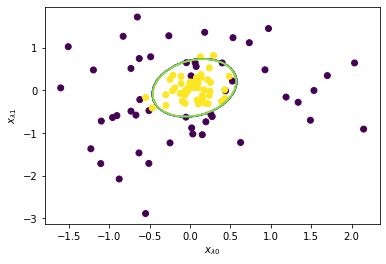

In [22]:
X0 = t.randn(50, 2)
X1 = t.randn(50, 2) / 5

Y0 = t.zeros(50, 1)
Y1 = t.ones(50, 1)

X = t.cat([X0, X1], 0)
Y = t.cat([Y0, Y1], 0)


fig, ax = plt.subplots()
ax.set_xlabel("$x_{\lambda 0}$")
ax.set_ylabel("$x_{\lambda 1}$")
ax.scatter(X[:, 0], X[:, 1], c=Y[:, 0]);

X0 = X[Y[:, 0]==0, :]
X1 = X[Y[:, 0]==1, :]

mu0 = X0.mean(0)
mu1 = X1.mean(0)

C0 = (X0-mu0).t() @ (X0-mu0) / X0.shape[0]
C1 = (X1-mu1).t() @ (X1-mu1) / X1.shape[0]

N0 = MvNormal(mu0, C0)
N1 = MvNormal(mu1, C1)


x0range = t.linspace(*ax.get_xlim(), 500)
x1range = t.linspace(*ax.get_ylim(), 500)
x0s, x1s = t.meshgrid(x0range, x1range)
xs = t.stack([x0s, x1s], -1)

ax.contour(x0s, x1s, 0<(N1.log_prob(xs) - N0.log_prob(xs)));

<h2> Naive Bayes </h2>

What about when the data is variable-length?

For instance, consider classifying an email as spam/not-spam using just the number of each word (e.g. with "viagra" indicating spam and "Excel" indicating not-spam).

We take each word, $x_{\lambda, i}$, in an email, $x_\lambda$ to be given by a probability distribution over words,
\begin{align}
  P(x_{\lambda,i}=\text{viagra}| y_\lambda=\text{spam}) &= 0.6\\
  P(x_{\lambda,i}=\text{excel}| y_\lambda=\text{spam}) &= 0.1\\
  P(x_{\lambda,i}=\text{the}| y_\lambda=\text{spam}) &= 0.3
\end{align}
and
\begin{align}
  P(x_{\lambda,i}=\text{viagra}| y_\lambda=\text{not spam}) &= 0.05\\
  P(x_{\lambda,i}=\text{excel}| y_\lambda=\text{not spam}) &= 0.65\\
  P(x_{\lambda,i}=\text{the}| y_\lambda=\text{not spam}) &= 0.3
\end{align}

The "naive" part is that we take each word to be IID, so the probability of an email, $x_\lambda$, is a product over the probability of each word,
\begin{align}
  P(\x_\lambda| y_\lambda) = \prod_i P(x_{\lambda,i}| y_\lambda)
\end{align}

To compute the probability that an email is spam given the words in it, we need Bayes theorem,
\begin{align}
  \P{y_\lambda| \x_\lambda} &\propto \P{y_\lambda} \P{\x_\lambda| y_\lambda} %{\sum_{y \in \{\text{spam}, \text{not spam}\}} \P{y_\lambda=y}\P{\x_\lambda| y_\lambda=y}}
\end{align}

Where $\P{y_\lambda}$ is the prior, describing whether spam emails are more or likely than real emails,
\begin{align}
  P(y_\lambda=\text{not spam}) &= 0.2\\
  P(y_\lambda=\text{spam}) &= 0.8
\end{align}



The probability of the email, given it is spam is:
\begin{align}
  P(\x_\lambda=\text{viagra, the viagra}| y_\lambda=\text{spam}) =& P(x_{\lambda,1}=\text{viagra}| y_\lambda=\text{spam})\\
  &P(x_{\lambda,2}=\text{the}| y_\lambda=\text{spam})\\
  &P(x_{\lambda,3}=\text{viagra}| y_\lambda=\text{spam})\\
\end{align}

In [23]:
like_spam = 0.6*0.3*0.6
like_spam

0.108

The probability of the email, give it is not spam is:
\begin{align}
  P(\x_\lambda=\text{viagra, the viagra}| y_\lambda=\text{not spam}) =& P(x_{\lambda,1}=\text{viagra}| y_\lambda=\text{not spam})\\
  &P(x_{\lambda,2}=\text{the}| y_\lambda=\text{not spam})\\
  &P(x_{\lambda,3}=\text{viagra}| y_\lambda=\text{not spam})\\
\end{align}

In [24]:
like_notspam = 0.05*0.3*0.05
like_notspam

0.00075

We can immediately see that the email is most likely spam.

However, before we can fully reach that conclusion, we need to incorporate the prior and renormalise.

\begin{align}
  \P{y_\lambda| \x_\lambda} &\propto \P{y_\lambda} \P{\x_\lambda| y_\lambda}
\end{align}

In [25]:
propto_post_spam    = 0.8*like_spam
propto_post_notspam = 0.2*like_notspam

(propto_post_spam, propto_post_notspam)

(0.0864, 0.00015000000000000001)

In [26]:
post_spam    = propto_post_spam    / (propto_post_spam + propto_post_notspam)
post_notspam = propto_post_notspam / (propto_post_spam + propto_post_notspam)

(post_spam, post_notspam)

(0.9982668977469671, 0.001733102253032929)